# Facial Keypoint Detection

**Explorations on facial image keypoint detection.**  

This project contains the explorations on face feature detection (for the [Kaggle competition](https://www.kaggle.com/c/facial-keypoints-detection)), as part of the final project for the 207-Machine Learning course for [Berkeley's Master in Information and Data Science](https://datascience.berkeley.edu/).  

The project was developed by: [Alex](https://github.com/keivahn), [Ankit](https://github.com/ankittharwani), [Nina](https://github.com/kuknina) and [Will](https://github.com/willahscott).  


## Presentation
We created a [Prezi adventure](https://prezi.com/an_apyqfaeaj/recognizing-key-facial-points/#) to showcase our ideas and explorations.

## Contents of this notebook

* [GitHub Repo](#GitHub-Repo)  
* [Notebook Imports](#Notebook-Imports)  
* [Goal](#Goal)  
* [Approach](#Approach)  
* [Loading the Data](#Loading-the-data)  
* [Preprocessing](#Preprocessing)  
    * [Face Detection](#Face-Detection)  
    * [Dimensionality Reduction](#Dimensionality-Reduction)  
        * [PCA](#PCA)  
        * [GMM](#GMM)  
    * [Image Processing](#Image-Processing)  
        * [Edge Detection](#Edge-Detection)  
        * [Noise Reduction](#Noise-Reduction)  
        * [Finding Contours](#Finding-Contours)  
* [Models Explored](#Models-Explored)  
    * [Baseline - KNearest Neighbors](#Baseline---KNearest-Neighbors)  
    * [Neural Nets](#Neural-Nets)  
        * [Convolutional Neural Network](#Convolutional-Neural-Network)
    * [Bayes Classifiers](#Bayes-Classifiers)  
    * [Logistic Regression](#Logistic-Regression)  
    * [Trees](#Trees)  
    * [Ensemble](#Ensemble---Averaging)  
* [Final Model](#Final-Model)  
* [Conclusions and Remarks](#Conclusions-and-Remarks)  
* [Appendix](#Appendix)  


## GitHub Repo  

Given that we were 4 team members and we were planning on doing a more breadth-focused analysis, we created a [GitHub repository](https://github.com/WillahScott/facial-keypoint-detection) with a structure that would make our work **independent** but **compatible** as well a set of common `tools` that would create our explorations cleaner and more efficient.

The structure we came up with is as follows:  

* **`scripts/`**  

	* **`tools/`** contains a set of additional tools that make the exploration and modeling cleaner. For more information of the tools refer to the [Appendix-Tools](#Internal-Tools-Built). Some of the tools will be introduced throughout this notebook.  
        * `submit.py` - functions for generating the Kaggle submission files  
        * `getdata.py` - loading and preprocessing the datasets
        * `save4later.py` - basic pickler for storing and retrieving (and listing the available) models, as well as preprocessed dataset
    
	* **`explorations/`** contains dataset explorations, plots and initial modeling attempts  

    * **`preprocessors/`** contains the preprocessing scripts

	* **`modelers/`** contains all serious modeling attempts, including the generation of their submission files
    

* **`data/`**  

	* **`datasets/`** contains the original kaggle data  

	* **`preprocessed/`** contains preprocessed datasets. For *temporal* time-consuming preprocessings   

	* **`models/`** contains the persistent storages of the models created. Each pickled model contains: name, alias, description, model-object, prediction-df, [training-time], [predicting-time]  

    * **`submissions/`** contains the csv files submitted to the Kaggle competition  



## Goal

Identify the location of key facial features in an image:

<img src="img/goal.png" alt="Identifying facial keypoints" style="width: 500px;"/>

The correct identification of these keypoints in a face has multiple applications. From the Kaggle website:  
> This can be used as a building block in several applications, such as:
>* tracking faces in images and video
>* analysing facial expressions
>* detecting dysmorphic facial signs for medical diagnosis
>* biometrics / face recognition

However, the dataset includes several partial (or non-frontal) faces as well as some additional problematic images that present challenges, such as:

<img src="img/problems.png" alt="Challenges in face detection" style="width: 250px;"/>

  
## Approach  

Our approach will be to cover a wide variety of preprocessors (both generic machine learning algorithms or specific to image processing) and models. Once we have this set up, we will concentrate on the exploring theinteractions of these together.

The following image, from our [prezi adventure]() best summarizes the explorations:

<img src="img/full_approach.png" alt="Framework of our approach" style="width: 700px;"/>



## Notebook Imports

The following imports are based on the base-environment. Further imports relating to specific sections are contained within those sections.

In [1]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Due to how imports work in iPython notebooks, the standard relative import does not work when using a Jupyter Notebook, which would be:

```python
from ..tools import submit
```

The easiest way around it is to temporarily add the path to the `scripts/` subfolder to the `PYTHON_PATH` (the set of locations in which python will look to import packages). Below is the necessary snippet for loading the internal modules in `tools`:  

In [2]:
# import necessary for setting path
import sys, os

# add facial-keypoint-detection/scripts to the Python path
pathArr = os.getcwd().split("/")
scriptPath = '/'.join(map(str, pathArr[:len(pathArr)-1]))
sys.path.append(scriptPath)

# import my tools
from tools import save4later, getdata, submit

## Loading the data

Using the `tools/getdata.py` module we obtain the data.  

In [3]:
# Load data (no dev)
_loaded = getdata.load_data(0, test=True, nonas=True)

FEATURES = _loaded['features']
print 'Number of features:', len(FEATURES)

train_data = _loaded['training']['data']
train_labels = _loaded['training']['labels']
print 'Training dataset size: ', train_data.shape

test_data = _loaded['test']['data']
print 'Test dataset size: ', test_data.shape

Number of features: 30
Training dataset size:  (2140,)
Test dataset size:  (1783,)


### Data typing
Since the image is a 96 x 96 matrix with values ranging 0 through 255, the module performs some custom data typing. By enforcing the matrix to be a array of `np.uint8` the size of the datasets was reduced by approximately one full order of magnitude.  

Below is the snippet of the `getdata.py` function that enforces this:  
```python
def get_img(x):
	''' Preprocess images into unsigned 8byte integer arrays

	Usage: >> get_img(<string containing space-separated ints>)
	'''
	return np.uint8( map(int, x.split()) )
```  

### Partial faces

Both the test and training datasets contain partial faces (either because they are not frontal, or because the face has been cut off by the borders of the image). Although we performed some initial explorations with the whole set of faces, the team decided to simply use full frontal faces. *This is enforced through the `nonas=True` option in the `load_data` function, as explained below.*

Let's obtain the full dataset as well for exploration of the preprocessors.

In [6]:
# Load data (no dev)
_loaded_full = getdata.load_data(0, test=False, nonas=False)

train_full_data = _loaded_full['training']['data']
train_full_labels = _loaded_full['training']['labels']


### Train-Dev-Test Split  
The test dataset is provided by Kaggle (without any labels).  

For the purpose of this notebook we will load the full training data, and not split into train-dev. The `getdata.load_data` function provides this capability:

```python
def load_data(dev, test=False, nonas=True):
	''' Loads the datasets (test as well, if specified), preprocess images
		unsigned 8byte integers
    Inputs: 
        dev - if 0<dev<1 percentage of datapoints assigned to dev (vs train)
              if dev > 1 number of observations assigned to dev
              if dev < 0 number of observations assigned to training (the rest for dev)
        test - boolean, return test data
        nonas - filter NA observations from dataset (removes whole row with any NA)
        verbose - print informative status updates

    Outputs: { 'training': {'data': <ndarray>, 'labels': <ndarray> }, ... }

	Usage: >> load_data(<dev-size>, test=False, nonas=True)
	'''
    # ...
```

However, the great majority of the models were trained with the full training set (excluding partial images).

## Preprocessing

A significant amount of effort was put into researching and performing different types of preprocessors. 

The main reasons behind the preprocessing were:
* Dimensionality reduction
* Noise reduction, both by:  
    * getting rid of image noise, due to quality of the image, or uninteresting characteristics of the face   
    * helping our models *focus* their efforts on the parts of the image worth modeling  

We will devote a section for each of these three approaches.  

### Face Detection - Background Filtering  

Let's build a quick image plotting function so that later code can be read cleanly.

In [10]:
IMAGE_SIZE = 96

def plot_faces(faces, full=False):
    ''' Plots a set of faces '''
    dataset = train_full_data if full else train_data  # Choose the appropriate dataset
    fig, axes = plt.subplots(1,len(faces), figsize=(18,4))
    for i,face in enumerate(faces):
        axes[i].imshow(dataset[face].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.gray)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

By *the parts worth modeling* we mean the actual face in the image, and not background noise.

For example the following images:

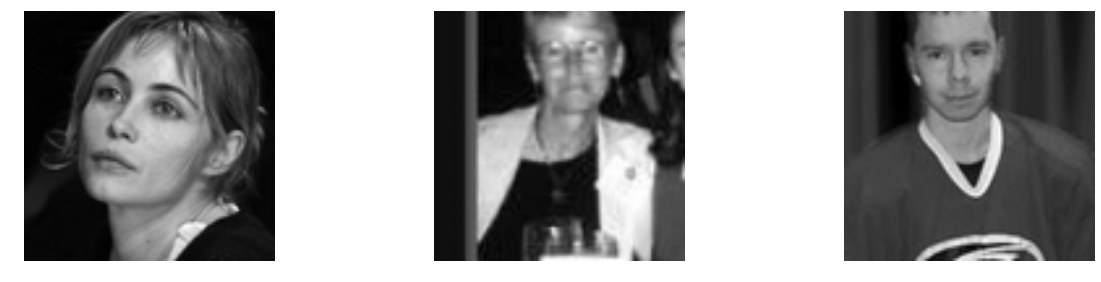

In [11]:
plot_faces([2151, 6765, 5117], full=True)

These images have some distracting background features (the right-most image does not have directly background but the hair could be crop out to reduce possible confusion, given the slightly veered axis of the face).

#### OpenCV

One of the computer vision frameworks is OpenCV, started at Intel in 1999 by Gary Bradsky. OpenCV is written in C++ but there are several libraries built it that permit its use from other languages, one of them being Python.

Prior versions of the library were not straightforward to set up, due to its dependencies with `numpy`/`scipy` and it needs to compile into C++, and therefore must be associated to a compiler. However, with conda, the set-up is painless (if using a standardly clean environment).

**In order to run this section the environment necessary is `ocv`, part of the [advanced-environments](#Environments).**

In [13]:
import cv2

#### Haar Classifier

OpenCV's comes with a trained Haar Classifier that implements the [Viola-Jones algorithm](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework). Refer to the [original paper](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=585C7246498233B7C16892BBE094144C?doi=10.1.1.10.6807&rep=rep1&type=pdf) for more detail on the cascade-boosting approach.

In [14]:
# Haar classifier code
CASC_PATH = '../haarcascade_frontalface_default.xml'

# Create the haar cascade classifier
faceCascade = cv2.CascadeClassifier(CASC_PATH)

def detect_face(img, min_face_size):
    ''' Detect faces in the image'''
    face = faceCascade.detectMultiScale(
        img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(min_face_size, min_face_size),
        flags = cv2.cv.CV_HAAR_SCALE_IMAGE)
    return face

This makes use of the configuration file `haarcascade_frontalface_default.xml` that implements the Haar classifier.  
  
Let's create a function for plotting detected faces of images (and use it on these three images)

In [15]:
def plot_face_detect(faces, min_face_size=10, full=False):
    ''' Plots a bunch of faces '''
    dataset = train_full_data if full else train_data  # Choose the appropriate dataset
    fig, axes = plt.subplots(1,len(faces), figsize=(18,4))
    
    for i,face in enumerate(faces):
        img = dataset[face].reshape(96,96)

        # Detect faces
        face = detect_face(img, min_face_size)

        # Plot image and rectangle on the face detected
        axes[i].imshow(img, cmap=plt.cm.gray)
        axes[i].axis('off')
        for (x,y,w,h) in face:
            _rect = patches.Rectangle( (x,y), w, h, fill=False, color='orange', lw=3)
            axes[i].add_patch(_rect)
    
    plt.tight_layout()
    plt.show()

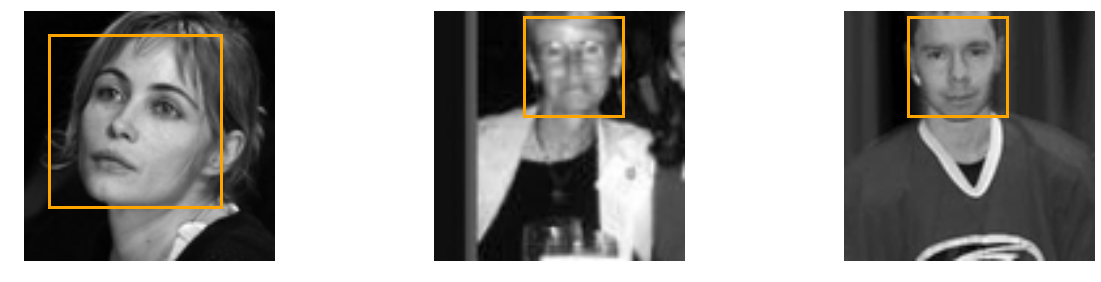

In [18]:
plot_face_detect([2151, 6765, 5117], full=True)

#### Background Removal

Now that we have identified the faces, we just have to remove the image background.

In [22]:
def mask_faces(faces, full=False):
    ''' Masked faces detected '''
    dataset = train_full_data if full else train_data  # Choose the appropriate dataset
    masked = []
    
    for i,_face in enumerate(faces):
        old_img = dataset[_face].reshape(96,96)
        
        # detect face
        _face = detect_face(old_img, min_face_size=10)
                
        # only crop if we detect one face
        if len(_face) == 1:
            x, y, w, h = _face[0]
            new_img = np.zeros_like(old_img)
            new_img[y:y+h, x:x+w] = old_img[y:y+h, x:x+w]
            
            masked.append(new_img.flatten())
            
        else:
            masked.append(old_img.flatten())
        
    return masked

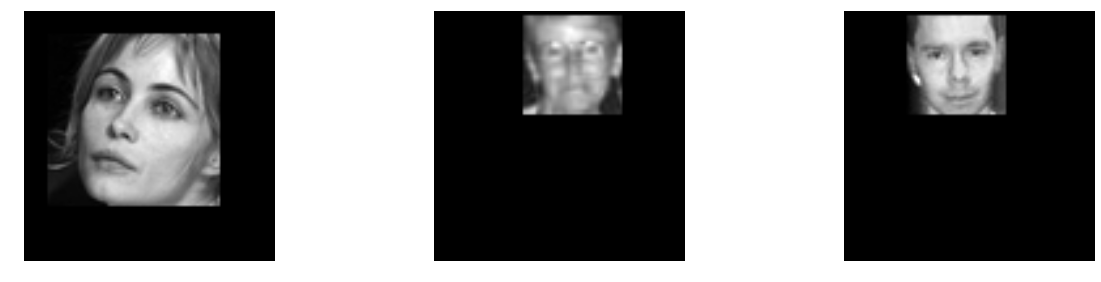

In [24]:
# Mask
faces_masked = mask_faces([2151, 6765, 5117], full=True)

# Plot masked
fig, axes = plt.subplots(1,3, figsize=(18,4))
for i, fac in enumerate(faces_masked):
    axes[i].imshow(fac.reshape(96,96), cmap=plt.cm.gray)
    axes[i].axis('off')
fig.tight_layout()
plt.show()

#### Further Reference  
For further detail on the explorations on face detection refer to [`explorations/face-detection.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/face-detection.ipynb) and [`explorations/preprocessed-face-detection.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/preprocessed-face-detection.ipynb) notebooks. For the full preprocessor, refer to [`preprocessors/preprocessors.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/preprocessors/preprocessors.ipynb).

### Dimensionality Reduction  

Our data has many dimensions: 96 x 96 features, each ranging values between 0 and 255.

#### PCA   

Based on the readings from the course, PCA can be used to reduce face image dimensionality by creating *eigenfaces* [see *Eigenfaces for Recognition* by Turk and Pentland].  

By reducing the dimensionality of our images we hope our models not only focus on the more significant features of our faces, but also are able to obtain more competitive model training performances.  


In [25]:
from sklearn.decomposition import PCA

In [32]:
NUM_COMP = 250

_st = time.time()  # start timer

# PCA
pca = PCA(n_components = NUM_COMP)
pca_train_data = pca.fit_transform(train_data.tolist())

_time = time.time() - _st # stop timer

pca_test_data = pca.transform(test_data.tolist())

# Calculate variance explained
exp_var = np.sum(pca.explained_variance_ratio_ )

# Report
print '     Principal Components Analysis\n     =============================\n'
print ' + Number of components: {n}'.format(n=NUM_COMP)
print ' + Elapsed (training) time: {t:.1f}s'.format(t=_time)
print ' + Cumulative variance explained: {v:.3%}'.format(v=exp_var)


     Principal Components Analysis

 + Number of components: 250
 + Elapsed (training) time: 11.0s
 + Cumulative variance explained: 95.758%


#### Further Reference  
For further detail on the explorations on face detection refer to the [`explorations/nina_explorations.ipynb.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/nina_explorations.ipynb) notebook. For the full preprocessor, refer to [`preprocessors/PCA.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/preprocessors/PCA.ipynb).

#### GMM  

Gaussian Mixture Models were used as a side-tool in order to help the team detect "weird" images. 

By fitting a GMM model with the labels of a specific feature, for example the nose center (both x and y). With this GMM model we would be able to generate a matrix of the probability of the nose center being in a certain pixel of the image.  

Given the secondary nature of this analysis, it is omitted from the main notebook, refer to the [`explorations/nina_explorations.ipynb.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/nina_explorations.ipynb) notebook for some initial explorations involving GMM.

### Image Processing   

In order to get rid of image noise (due to quality of the image or simple noise in the images) and concentrate on  characteristics of the face we did extensive research. Mainly guided by OpenCVs documentation and O'Reillys OpenCV [book](http://www.amazon.com/Learning-OpenCV-Computer-Vision-Library/dp/0596516134).  

Additionally, most of the preprocessors initially explored on OpenCV were later used directly from the `scikit-image` package (given that this package is included in the *base-environment*).  

Let's create a function that, given a transformation, plots the original and the transformed image for a small sample of images in our dataset.

In [34]:
def plot_transform(faces, transform):
    ''' Plots the original and transformed image of the specified faces '''
    fig, axes = plt.subplots(2,len(faces), figsize=(18,6))
    
    for i, f in enumerate(faces):

        # Plot original
        _img = train_data[f].reshape(IMAGE_SIZE,IMAGE_SIZE)
        axes[0, i].imshow(_img, cmap=plt.cm.gray)
        axes[0, i].axis('off')
        
        # Plot transformed
        _tr = transform(_img)        
        axes[1, i].imshow(_tr, cmap=plt.cm.gray)
        axes[1, i].axis('off')


Our efforts can be classified into three main subsections, based on their main goal:

#### Edge Detection  

Edge detection efforts mainly focus on calculating the difference of a given pixel with its surrounding neighbors. For this several discrete differentiation calculations can be performed. We tried mainly two:

##### Sobel Filters
A Sobel filter (or [Sobel-Feldman operator](https://en.wikipedia.org/wiki/Sobel_operator)) is an approximation to the images gradient (and therefore called, discrete differentiation operator). Let's take a look at an example

In [33]:
from skimage.filters import sobel

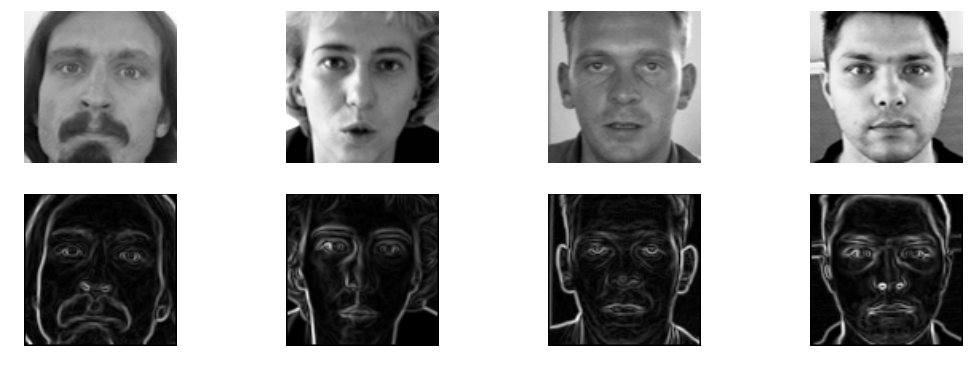

In [35]:
plot_transform([0,1,2,3], sobel)

##### Laplace Transform
Used for similar purposes, the [Laplace transform](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/laplace_operator/laplace_operator.html) performs a discrete analog of the Laplacian transform, and can be used for similar purposes in edge detection.

In [36]:
from skimage.filters import laplace

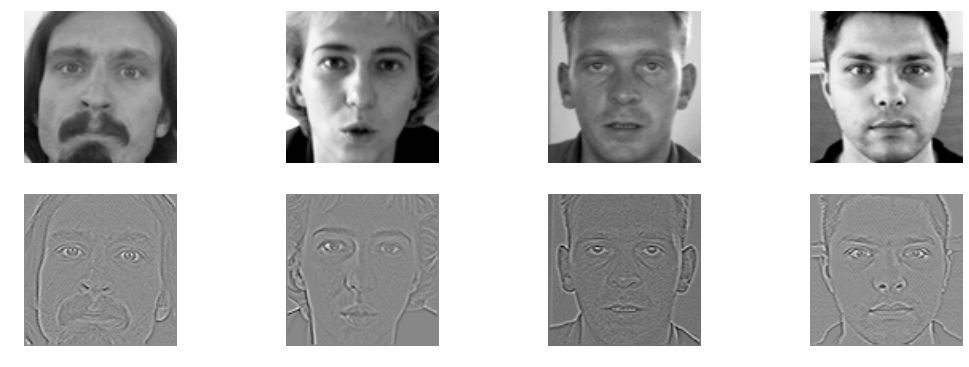

In [37]:
plot_transform([0,1,2,3], laplace)

#### Noise Reduction

Noise reduction is mainly performed to eliminate extraneous noise and "uninteresting" pixels from the image, which may be due to image quality or due to the face, for example like pimples or freckles.  

These preprocessors mainly average the pixels with the value of those surrounding them. For example:

##### Gaussian Blur

A [gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) assigns the value of the weighted (gaussian weights) mean of the surrounding pixels to any specific pixel in the image.

In [38]:
from skimage.filters import gaussian

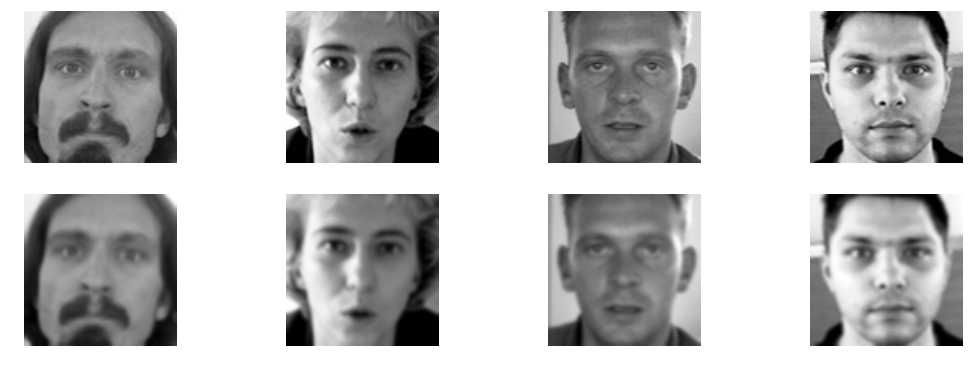

In [40]:
tr_gaussian = lambda x: gaussian(x, sigma=1, mode='mirror')
plot_transform(range(4), tr_gaussian)

Although the gaussian blur by itself might seem to not add enough different information, the combination with other filters using a gaussian blur is a common practice.

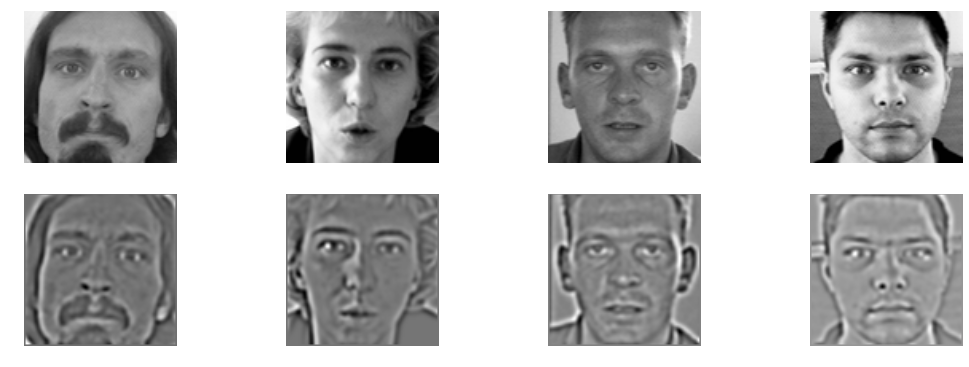

In [42]:
lap_gauss = lambda x: laplace(gaussian(x, sigma=1.5, mode='mirror'))
plot_transform(range(4), lap_gauss)

#### Finding Contours

Lastly, similar to edge detection, finding contours (areas of similar coloring or connected by a bordering edge) is another approach at reducing the information of an image while accentuating certain characteristics.  

In the case of image detection, we were looking for ways to obtaining contours for eyes abd mouth mainly, as if they were circled out.  

##### Histogram of Oriented Gradients

A [Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) (or HOG) subdivides an image into smaller square regions of pixels, and looks for oriented lines in each of the regions. One of the parameters for tuning the HOG is the number of line orientations to look for, 4 would be just up/down and left/right, while 8 includes also the diagonals.

We found that applying a HOG with a subsequent gaussian blur seemed to produce possibly interesting images.  

In [43]:
from skimage.feature import hog

In [44]:
def get_hog(img):
    ''' Perform Histogram of Oriented Gradients '''
    # Histogram of Oriented Gradients (HOG)
    _, _hog = hog(img, orientations=8, pixels_per_cell=(10, 10),
                    cells_per_block=(1, 1), visualise=True)
    return _hog

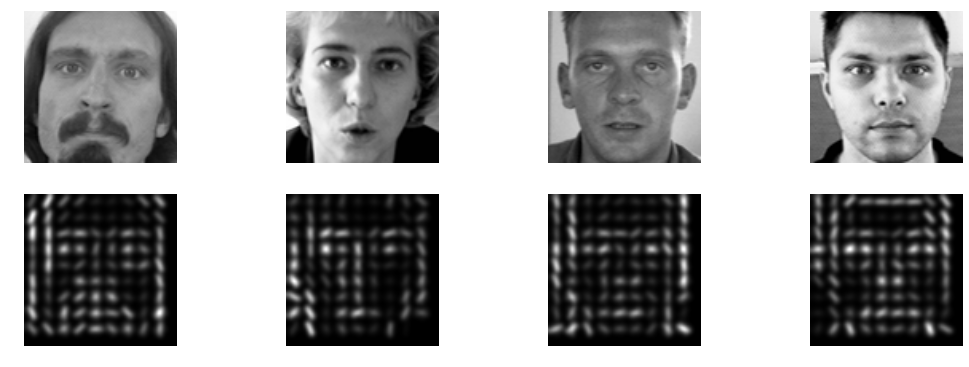

In [46]:
gauss_hog = lambda x: gaussian(get_hog(x), sigma=1.5, mode='mirror')
plot_transform(range(4), gauss_hog)

#### Further Reference  
For further detail on the explorations on face detection refer to [`explorations/image-processing.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/image-processing.ipynb) and [`explorations/preprocessed-face-detection.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/preprocessed-face-detection.ipynb) notebooks. For the full preprocessor, refer to [`preprocessors/preprocessors.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/preprocessors/preprocessors.ipynb).


###  Preprocessed data storage

All the preprocessed datasets were appropriately saved using the `save4later.save_preprod` function. Specified below:
```python
def save_preprod(preprod, label, description=None, overwrite=False):
	''' Saves a specific preprocessed dataset with a given label and description 
	
		Inputs:
			preprod - dataset to save
			label - name of the file in which the dataset will be saved (extension not neessary)
			description - [Optional] human-readable description of the dataset saved (strongly recommended)
			overwrite - [Optional] boolean, necessary to be set to True for overwriting a file 
	'''
	# ...

```

With `list_preprods` we can obtain the list of all the preprocessors stored:

In [47]:
save4later.list_preprods()


    PREPROC'D DATASETS
 Total: 10

  + bhog_nonas.pk : Blurred HOG (only faces with no NA features)
  + sobel_nonas.pk : Sobel filter (only faces with no NA features)
  + masked_nonas.pk : Masked data (only faces with no NA features)
  + pca_trained.pk : trained data transormed with 250-component PCA
  + pca_transformed.pk : test data transormed with 250-component PCA
  + masked.pk : Masked data (removed background of all faces)
  + lapgauss_nonas.pk : Laplace+Gaussian transform (only faces with no NA features)
  + test.pk : This is a test
  + orig_sobel_nonas.pk : Original + Sobel filter (only faces with no NA features)
  + gauss_nonas.pk : Blurred images (only faces with no NA features)


## Models Explored

Given that the intended outcome is predicting the x and y location of 15 distinct facial keypoints (which amounts to a total of 30 predictions for each face), whenever we refer to a *model*, we are indeed referring to a model capable of producing these 30 predictions. In most cases this is more *a suite of models* than a single model itself.  

Two models were used as clear starting points: K-Nearest-Neighbors and Multinomial Naïve-Bayes.  

### Baseline - KNearest Neighbors

An initial submission was performed with a K-Nearest-Neighbors model *trained* on the dataset without NAs (since the NAs added some amount of complication to the distance calculation) as well as the size increased sufficiently the prediction performance.  

This model was intended to be as out-of-the-box as possible, with no preprocessors nor parameter calibration. We used the standard Euclidean distance.

The simple structure to create and train 30 separate models is replicated further, with greater complexity, due to the hyperparameter calibrations. So let us use this basic snippet to illustrate future structure of model training:

```python
# Suite of models
knn_regressors = []

# Get all models
for i, facial_feature in enumerate(FEATURES):
    
    # Initialize and train
    knn = KNeighborsRegressor()
    knn.fit(train_data.tolist(), train_labels[:,i])
    
    # Append to suite of models
    knn_regressors.append( (facial_feature, knn) )
```

### Bayes Classifiers  

A Multinomial Naïve Bayes Classifier was used as part of the initial experimentation phase. Typically, this such modeling problem is considered more of a regression problem, since we are trying to estimate where a given feature is in a face, rather than other *standard* classification problems.

However, this model is applying the following classification problem: to which class does this image belong, if each class is defined for the place in which the nose is? Given that the images are 96 x 96, and we have one feature for x and one for y, this classification problem is simply trying to classify among the 96 *classes* available. And therefore the model *works*.

This model has the downside that it is losing the ordering quality and the smoothness of what our actual feature does, in fact, have.  

The upside of this model is the great performance of the training and prediction time. Therefore it was used among some initial explorations of model-preprocessor interaction.

Given the usability of this, we created a function that would return the model suite given a specific dataset (in which we could change the different datasets). 

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

In [50]:
def MultiNBfit(training_data, training_labels, features,
               parameters = {'alpha':[0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}):
    """A function that takes some training data and some parameters of interest and 
    returns a list of fitted multinomial naive bayes model on that training data where
    each model corresponds with a column in the training labels data and is optimized
    for the given alpha values"""
    
    # create an array to store the models
    multinomials = []
    
    # loop through all the possible features
    for index,feature in enumerate(features):
        
        # initalize the multinomial naive bayes model
        multinomial = MultinomialNB()
        
        # set the search for the optimal alpha given our parameter options
        alpha_search = GridSearchCV(multinomial,parameters)
        
        # fit the search model to the training data
        alpha_search.fit(training_data, training_labels[:,index])
        
        # find the best alpha value
        best_alpha = alpha_search.best_params_
        
        # fit a model with the best alpha value (smoothing)
        multinomial_optimal = MultinomialNB(alpha = best_alpha['alpha'])
        multinomial_optimal.fit(training_data, training_labels[:,index])
        
        # create a tuple with the model and its associated facial feature
        appending = feature, multinomial_optimal

        # append the model and its name to our list
        multinomials.append(appending)
        
    # return the list of models
    return multinomials

The above function uses Grid Search to estimate the best smoothing parameter `alpha` for each feature-model.  

Having this structure set forth, and using the `save4later` module, training different models and storing them for future evaluation and comparison became a very clean task:

Loading  
```python
# load the masked training data
train_masked = save4later.load_preprod("masked_nonas")

# load more datasets ...
```

Training and saving
```python
multi_base = MultiNBfit(train_data.tolist(),train_labels, FEATURES)
save4later.save_model(multi_base, 'Multi_NB', 
                     'Multinomial naive bayes without preprocessed data with no NAs', overwrite=True)
# train + save more...
```
  
Create Kaggle Submission
```python
submit.create_generate(multi_base, model, 'MultNB', verbose=False)
# create submission csv's for more ...
```

#### Further Reference  
For more detailed explorations on the use of Multinomial NB refer to the [`alex_explorations.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/alex_explorations.ipynb) notebook. For the full modeler (model creation) notebook refer to <a href="https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/modelers/Naive%20Bayes%20v2%20(auto).ipynb" target="_blank">`Naive Bayes v2 (auto).ipynb`</a>.



### Neural Nets

Neural Networks were explored using Theano library, in conjunction with lasagne and nolearn, for a cleaner more structured construction, therefore: 

**In order to run this section the environment necessary is `lnet`, part of the [advanced-environments](#Environments).**  

In [ ]:
# Theano imports + initialization
import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
device = theano.config.device  # using CPU
floatConf = theano.config.floatX  # 64bit

# Lasagne + nolearn
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

Neural Networks are significantly different from the other models explored in the scope of this project. Two main features distinguish them from the rest:  
*  Neural Nets predict all 30 outputs together, and therefore don't have the feature independence assumption (similar to the Bag of Words for Naïve Bayes) we are making with other standard *suite of models*.
*  Given their layered construction, Neural Nets (and specially those that include deep learning) do not need features extraction since the different layers will perform as advanced feature extractors.  

The challenge for neural networks is mainly getting enough sample and training the network in reasonable amounts of time.  

Below, a standard Neural Net approach is illustrated

In [ ]:
def NNFunc(data, label):
    net = NeuralNet(
        layers=[
            ('input', layers.InputLayer),
            ('hidden', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        # layer parameters:
        input_shape=(None, 9216),  
        hidden_num_units=100,
        output_nonlinearity=None, 
        output_num_units=30,

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,

        regression=True,  # flag to indicate we're dealing with regression problem
        max_epochs=400,  # total epochs to train
        verbose=0,
        )
    net.fit(data, label)
    return net

We can check some of the outputs of the base Neural Network (as commented above, the network predicts all 30 outputs at the same time for each image):

```python
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

y_pred = net1.predict(train_data)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    plot_sample(train_data[i], y_pred[i], ax)

plt.show()
```
  
Which produces:
  
<img src="img/NN_output.png" alt="Neural Net output" style="width: 500px;"/>



#### Convolutional Neural Network  

Given that a great number of the latest (and best) image detection algorithms make use of Convolutional Neural Networks, we found it necessary to explore this methodology.  

Following [Daniel Nourian's tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) we were able to configure and set up an environment for running CNNs (refer to the [appendix](#Environments) for more detail on environments, and [here](https://github.com/WillahScott/facial-keypoint-detection/tree/master/adv-envs) for the complete documentation on setting up the CNN environment).

Unfortunately, we did not fully run any CNN (although we did make sure the first epochs worked flawlessly) since the most basic we set up was already estimated at 20+ hours of computation. This is a point in which the team has noted that setting up a AWS / Google Cloud instance could help generate a powerful model.  

For this deep learning algorithm we did not use any preprocessings, since the "deep" nature already acts as a features engineer, and also for comparison purposes (would the CNN find better features than if we used usual computer vision tools for feature engineering?).  

The following code is a snippet of how the base Neural Network structure was expanded to create a CNN:

```python
cnn = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=1000,
    verbose=1,
    )

cnn.fit(train_data_2d, train_labels)
```


#### Further Reference  
For more detailed explorations on the use of Neural Networks refer to [`CNN.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/CNN.ipynb) and [`CNN-will.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/CNN-will.ipynb) notebooks. For the full modeler (model creation) notebook refer to [`NN.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/modelers/NN.ipynb).


### Logistic Regression  

Back to the *suites of models* we implemented a set of 30 models that predicted each feature location. The optimal `C` (inverse of) regularization hyperparameter was estimated for each feature-model using Grid Search:

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
def logistic(training_data, training_labels, features, regularization="l2", save=False,
             Lparameters = {'C':[0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]}):
    """A function that takes some training data and some parameters of interest and 
    returns a list of fitted logistic regression models on that training data where
    each model corresponds with a column in the training labels data and is optimized
    for the given regularization values"""
    # create a list to hold logistic regressions
    logistics = []

    # loop through every facial feature
    for index,facial_feature in enumerate(FEATURES):

        # initalize the logistic regression model
        logistic = LogisticRegression()

        # set the C search with the given C options and the logistic model
        C_search = GridSearchCV(logistic,Lparameters)

        # fit the Gridsearch model to the data
        C_search.fit(train_data.tolist(),train_labels[:,index])

        # find the best C parameter
        best_C = C_search.best_params_

        # initalize a model with the best C
        logistic_optimal = LogisticRegression(C = best_C['C'])
        logistic_optimal.fit(train_data.tolist(),train_labels[:,index])
        logistic_optimal = logistic.fit(train_data.tolist(),train_labels[:,index])

        # create a tuple with the name of the feature and the model
        appending = facial_feature, logistic_optimal

        # append the name and the model to our list of facial feature models
        logistics.append(appending)

    # save the models for later
    if save:
        save4later.save_model(logistics, 'Logistic', 
                              'Logistic regression with non-preprocessed data with no NAs',overwrite=True)

Explorations incorporated some parameter tweaking, and playing around with the "L1" and "L2" regularizations.  

Intuitively, we would expect that using a "L1" regularization we would obtain a model that mainly has a set of "active" pixels that are the only ones to look at specific, while all others would be turned off.  

For "L2", we would expect to obtain bigger active pixel regions, but in which each pixel would amount to less information. 

Logistic Regression models obtained a high accuracy, but indicated clear signals of overfitting (training set accuracy of ~100% while test set accuracies ~97%). Training times ranged between ~20 minutes to 2 hours depending on the training set used.  

Given the high level of overfitting the team briefly experimented as well with ensemble techniques (as described in next section).

#### Further Reference  
For more detailed explorations on the use of Logistic Regression models refer to the [`alex_explorations.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/explorations/alex_explorations.ipynb) notebook. For the full modeler (model creation) notebook refer to [`LogisticRegression.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/modelers/LogisticRegression.ipynb) and [`LogReg-submitter.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/modelers/LogReg-submitter.ipynb) notebooks.



### Trees and Ensembles

As described in the previous section, some models started showing clear signs of overffiting. In order to deal with overfitting, the team decided to try some Ensemble Methods, by creating more overfitted models, and then aggregating this biased models using a simple averaging ensemble combiner.  

Standard candidates to produce overfit models are always Decision Trees and Random Forests. Using a high number of estimators, high number of features, and not performing much tree pruning, decision tree models tend to overfit quite fast.

The following function generates a (mainly overfit) trained tree on the specified dataset:

In [53]:
from sklearn.tree import DecisionTreeRegressor

In [54]:
def decision_tree(data, data_labels, model_label, description, verbose=True, save=False):
    ''' Initialize decision tree regressor suite of models '''
    dtr_list = []
    if verbose:
        print "{:30} Accuracy".format("Model")
    for feat in xrange(30):

        dtr = DecisionTreeRegressor(criterion="mse", splitter="best", random_state=0, max_features=100)
        dtr.fit(data, data_labels[:,feat])

        dtr_list.append( (FEATURES[feat], dtr) )
        
        if verbose:
            print " - {f:<27} {a:.3%}".format(f=FEATURES[feat],a=dtr.score(data, data_labels[:,feat]))
    
    if save:
        save4later.save_model(dtr_list, model_label, description, overwrite=True)
    
    return dtr_list

#### Random Forests

A similar function was used for creating trained Random Forests:

In [55]:
from sklearn.ensemble import RandomForestClassifier 

In [56]:
def random_forest(data, data_labels, model_label, description, verbose=True, save=False):
    ''' Initialize random forest regressor suite of models '''
    rf_list = []

    if verbose:
        print "{:30} Accuracy".format("Model")

    for feat in xrange(30):
        rfc = RandomForestRegressor(criterion="mse", n_estimators=500, max_features="log2")
        rfc.fit(data, data_labels[:,feat])

        rf_list.append( (FEATURES[feat], rfc) )
        
        if verbose:
            _acc = abc.score(data, data_labels[:,feat])
            print " - {f:<27} {a:.3%}".format(f=FEATURES[feat],a=_acc)
    
    if save:
        save4later.save_model(rf_list, model_label, description, overwrite=True)
    
    return rf_list

#### Further Reference  
For more detailed explorations/modelers on the use of Trees and Random Forest models refer to the [`DecisionTree.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/modelers/DecisionTree.ipynb) and  [`Ensemble.ipynb`](https://github.com/WillahScott/facial-keypoint-detection/blob/master/scripts/modelers/Ensemble.ipynb) notebooks.


### Ensemble - Averaging

Due to time constraints, and Kaggle's limited number of submissions per day, the team was not able to submit the averaging ensemble of the overfit Logistic Regression and Decision Trees.

## Final Model  

The team has not focused on obtaining a cutting edge accuracy in the Kaggle competition, but obtained a set of reasonable accuracies with the different approaches.  

The team finally selected two main models:  

* **Logistic Regression** on the Background removed data - which obtained a 3.82 public score  
* **Neural Networks** on the raw dataset - which obtained a 3.99 public score  

  
### Submissions

Submissions were created using the `tools/submit.py` module. The following function generates the csv file, taking as input a suite of models and a label for the submission file to be created.

```python
def create_generate(test, models, label='baseline', verbose=False):
    ''' Predicts using models and generates the csv file for submission.
    Wrapper for create_submission and generate_csv.
    Inputs: 
        test - test dataset on which to predict
        models - list of tuples: [ (feature, model), ... ]
        label - label for identification of the submission file
        verbose - print informative status updates

    Usage: >> create_generate( <test_data>, <list_of_models> [, <label> ] )
    '''
    # ...
```

With this tool, integrated with the rest of coordinated functions and datatypes, submission creation was seamless and easily shareable.  

### Accuracy measures

Accuracies measures are based on Kaggle's evaluation score for the competition: the mean of the Root Mean Squared Error of the distance of the predicted feature point with the actual:

$$\sqrt{\frac{1}{n}\sum_{t=1}^{n}e_t^2}$$


## Conclusions and Remarks

Overall, our breadth-oriented project has lead to a vast amount of leg work covering different types of image preprocessors, machine learning modeling techniques and specially, the combination of these.  

Our main lessons learned from the project can be summarized in:
* Significant improvements in execution and memory with **careful data typing** (e.g. using `numpy`'s `uint8` type for the image matrices reduced one order of magnitude in storage space).
* **Preprocessing improvements with SOME of the models** (i.e. Logistic Regression performs better with masked images, however few other models performs better with the preprocessed datasets)
* **Complex models (CNN) beyond our resource ability**. Although some of the laptops in the team were as new as March 2016, with expanded RAM and storage, use of GPUs is necessary for CNNs or big image datasets.

### Improvements  
Additionally, the team believes, that in retrospect areas for improvement would have been (watch out for v2.0!):  
* **Exploit interdependencies between facial features** (i.e. the y-value of the eyes should be reasonably similar, the nose x-coord must in between the x-coords of the eyes, etc...)  
* **Focus on simple preprocessors** to better fine-tune the images for the specific needs of each model  
* Paired with reving up our computing capabilities is the **expansion of the dataset**. Going beyond full faces and introducing some image transformations as rotations, flips or projections to expand the "vocabulary" of the training data  


As a final conclusion, the key work has been more creating a working environment for active team-member participation, illustrated by our over 80 commits, with near-flawless integration (very few merges or problems occurred once the working framework was fully set-up).

Of course, the most important conclusion has been our enjoyment in coordinating our learning explorations in the engaging field of Machine Learning!  


## Appendix

### Environments  
Using conda and virtualenvironments was essential for having completely shareable code, independent of local characteristics and installs. It also allowed us to explore advanced configurations for more complex packages and frameworks such as [OpenCV](https://opencv-python-tutroals.readthedocs.org/en/latest/#), [Theano](http://deeplearning.net/software/theano/), [Lasagne](http://lasagne.readthedocs.org/en/latest/) and [nolearn](https://pythonhosted.org/nolearn/).

Usage of these environments was made painless by conda's easy environment creation and sharing. Any user that wants to replicate the exact environment we had just needs to download (or clone the repo) the `environment.yml` and:

```bash
$ conda env create -f adv-env/environment-ocv.yml
$ source activate fkd
```

More advanced configurations for usage of CNN was appropriately documented and can be found [here](https://github.com/WillahScott/facial-keypoint-detection/tree/master/adv-envs).  



### Internal Tools Built  

In order to enhance clean readable notebooks, compatible code sharing and easy continuation of paused lines of explorations, we built an internal library with the following modules:  
 
* `submit.py` - functions for Kaggle submission file generation  
* `getdata.py` - loading and preprocessing the datasets  
* `save4later.py` - basic pickler for storing and retrieving (and listing the available) models and preprocessed dataset.  

#### Documentation
All these modules have been appropriately documented with docstrings in their source scripts, making the documentation readily available using notebook magics:

In [ ]:
getdata.load_data?

Complete documentation of the `tools` modules can be found [here](https://github.com/WillahScott/facial-keypoint-detection/tree/master/scripts/tools).

#### Usage
Below is a basic example of usage of `save4later` since this was key for efficient functioning within the group:

```python
knreg = KNeighborsRegressor()
knreg.fit(train_data.tolist(), train_labels[:,0])

save4later.save_model(knreg, 'KNRegressor', 'K-nearest neighbors regressor with no preprocessing')
```

*Take a break*

```python
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor

model = save4later.load_model('KNRegressor')
```

And you are set to go.  

The same applies for preprocessed data:

```python
import numpy as np
import pandas as pd

# Load and do a lot of heavy preprocessing
save4later.save_preprod(preprocessed_data, 'Blur-Hough', 'Gaussian blur + Hough transform')
```

*Take a break*

```python
import numpy as np
import pandas as pd

shiny_data = save4later.load_model('Blur-Hough')
```